In [3]:
import backtesting

C:\Users\HP\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [1]:
from backtesting.test import SMA
import pandas as pd
import glob

C:\Users\HP\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

C:\Users\HP\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
C:\Users\HP\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


In [2]:
filename = "NFO_NIFTYMIDCAP_Future"
glob.glob(f"{filename}*.csv")

['NFO_NIFTYMIDCAP_Future_Dec2023.csv',
 'NFO_NIFTYMIDCAP_Future_Feb2024.csv',
 'NFO_NIFTYMIDCAP_Future_Jan2024.csv',
 'NFO_NIFTYMIDCAP_Future_Mar2024.csv']

In [3]:
all_csv_files = glob.glob(f"{filename}*.csv")

# read all csv files at once
df = pd.concat(pd.read_csv(csv_file) for csv_file in all_csv_files)
df.shape

(23681, 14)

In [11]:
df1 = df[['datetime','open','high','low','close','volume']]

In [12]:
df1['datetime'] = pd.to_datetime(df1.datetime,format="mixed")

C:\Users\HP\AppData\Local\Temp\ipykernel_13284\1482150303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['datetime'] = pd.to_datetime(df1.datetime,format="mixed")


In [13]:
data = df1.set_index('datetime')
data.rename(columns = {"open": "Open", "high": "High", "low":"Low", "close": "Close"}, inplace = True)

In [7]:
data

,Open,High,Low,Close,volume
datetime,,,,,
2023-12-01 09:15:00,9725.70,9729.95,9715.00,9727.60,2100
2023-12-01 09:16:00,9729.80,9760.00,9729.80,9760.00,17250
2023-12-01 09:17:00,9758.00,9760.00,9757.45,9757.45,13425
2023-12-01 09:18:00,9757.45,9757.45,9750.45,9754.05,2475
2023-12-01 09:19:00,9755.00,9760.75,9752.45,9759.00,7050
...,...,...,...,...,...
2024-03-22 15:25:00,10402.25,10403.30,10402.15,10403.30,1125
2024-03-22 15:26:00,10403.30,10403.40,10401.35,10401.35,4050
2024-03-22 15:27:00,10402.00,10403.35,10401.50,10403.35,975


In [23]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
sma200 = SMA(data.Close, 200)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close
data['X_SMA200'] = (close - sma200) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close
data['X_DELTA_SMA100'] = (sma100 - sma200) / close


# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2024-03-01', '2024-03-30')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

In [9]:
data.head(2)

,Open,High,Low,Close,volume,X_SMA10,X_SMA20,X_SMA50,X_SMA100,X_SMA200,...,X_DELTA_SMA20,X_DELTA_SMA50,X_DELTA_SMA100,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_Sentiment,X_day,X_hour
datetime,,,,,,,,,,,,,,,,,,,,,
2023-12-01 14:43:00,9778.0,9778.0,9775.0,9775.0,225.0,-0.000573,-0.000871,-0.000554,-1.793350e-04,0.000499,...,0.000317,0.000375,0.000678,-0.000915,0.001770,-0.000033,0.001803,1.0,4.0,14.0
2023-12-01 14:45:00,9774.0,9776.8,9774.0,9776.8,75.0,-0.000268,-0.000648,-0.000387,2.045659e-07,0.000658,...,0.000261,0.000387,0.000658,-0.000496,0.001596,-0.000325,0.001921,1.0,4.0,14.0


In [21]:
data['X_Sentiment'].value_counts()   
# 1.0 - > return is positive
# 0.0 -> retunr is around zero
# -1 -> return is negative 


X_Sentiment
1.0    17752
0.0     5631
Name: count, dtype: int64

In [16]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Classification accuracy:  0.9022302904564315


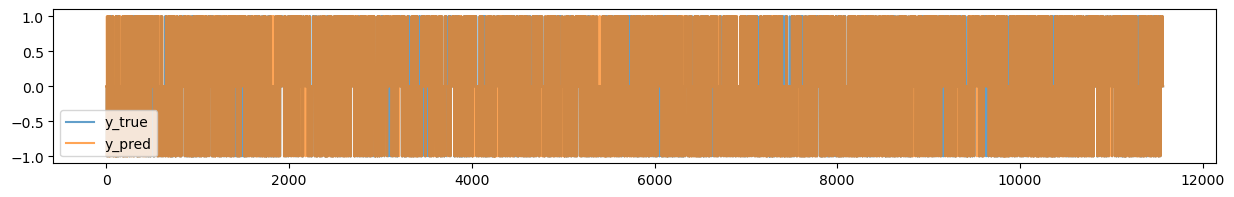

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(3)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [19]:
y_test, y_pred

(array([0., 0., 0., ..., 1., 0., 0.]), array([0., 0., 0., ..., 1., 0., 0.]))

In [61]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'volume', 'X_SMA10', 'X_SMA20',
       'X_SMA50', 'X_SMA100', 'X_DELTA_SMA10', 'X_DELTA_SMA20',
       'X_DELTA_SMA50', 'X_MOM', 'X_BB_upper', 'X_BB_lower', 'X_BB_width',
       'X_Sentiment', 'X_day', 'X_hour'],
      dtype='object')

In [25]:
from backtesting import Backtest, Strategy

N_TRAIN = 20000


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(3)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

C:\Users\HP\AppData\Local\Temp\ipykernel_13284\2381857173.py:61: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
C:\Users\HP\AppData\Local\Temp\ipykernel_13284\2381857173.py:61: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)


Start                     2023-12-04 13:32:00
End                       2024-03-22 15:29:00
Duration                    109 days 01:57:00
Exposure Time [%]                    4.490166
Equity Final [$]                  10683.31564
Equity Peak [$]                   10893.03708
Return [%]                           6.833156
Buy & Hold Return [%]                5.003533
Return (Ann.) [%]                   27.303259
Volatility (Ann.) [%]               12.681478
Sharpe Ratio                         2.153003
Sortino Ratio                        5.815528
Calmar Ratio                         3.626463
Max. Drawdown [%]                   -7.528895
Avg. Drawdown [%]                   -1.026967
Max. Drawdown Duration        6 days 21:54:00
Avg. Drawdown Duration        0 days 09:00:00
# Trades                                   40
Win Rate [%]                             55.0
Best Trade [%]                       0.946128
Worst Trade [%]                     -0.528135
Avg. Trade [%]                    

In [ ]:
bt.plot()

Classification accuracy:  0.9101123595505618


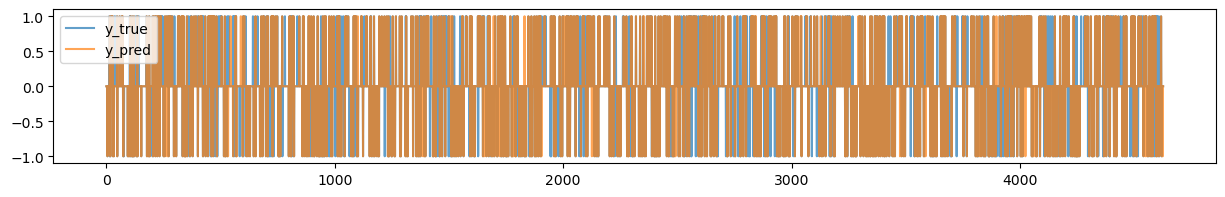

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

clf = RandomForestClassifier(50)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [27]:
from backtesting import Backtest, Strategy

N_TRAIN = 20000


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = RandomForestClassifier(50)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

C:\Users\HP\AppData\Local\Temp\ipykernel_13284\430983043.py:61: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
C:\Users\HP\AppData\Local\Temp\ipykernel_13284\430983043.py:61: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)


Start                     2023-12-04 13:32:00
End                       2024-03-22 15:29:00
Duration                    109 days 01:57:00
Exposure Time [%]                     3.27381
Equity Final [$]                  10124.82842
Equity Peak [$]                   10545.78902
Return [%]                           1.248284
Buy & Hold Return [%]                5.003533
Return (Ann.) [%]                    4.634937
Volatility (Ann.) [%]               14.062062
Sharpe Ratio                         0.329606
Sortino Ratio                        0.626453
Calmar Ratio                         0.853021
Max. Drawdown [%]                   -5.433553
Avg. Drawdown [%]                   -0.995286
Max. Drawdown Duration        6 days 21:58:00
Avg. Drawdown Duration        0 days 15:02:00
# Trades                                   52
Win Rate [%]                             50.0
Best Trade [%]                        0.42667
Worst Trade [%]                     -1.007408
Avg. Trade [%]                    